In [1]:
# CELL 0: Connect to DBRepo, Download Datasets using PIDs

import getpass
import requests
from dbrepo.RestClient import RestClient
import pandas as pd
import os
from pathlib import Path

print("--- Preparing to download data from DBRepo ---")

# --- DBRepo Connection ---
# Prompt for password securely (won't be saved in notebook output)
username = "bbaltal" # Make sure this is your correct TU Wien username
try:
    password = getpass.getpass("Enter DBRepo password: ")
except Exception as e:
    print(f"Could not get password interactively: {e}")
    # Handle error appropriately, maybe raise it or exit
    raise

# Establish connection
print(f"Connecting to DBRepo as user: {username}...")
try:
    client = RestClient(
        endpoint="https://test.dbrepo.tuwien.ac.at",
        username=username,
        password=password
    )
    # Optional: Add a check here if the client library provides one, e.g., client.check_connection()
    print("Connection successful.")
except Exception as e:
    print(f"Failed to connect to DBRepo: {e}")
    # Handle error appropriately
    raise
# --------------------------

# --- Define Datasets and PIDs ---
# Dictionary mapping desired local filename to its DBRepo PID
splits = {
    "regular_train.csv": "4421e56c-4cd3-4ec1-a566-a89d7ec0bced",
    "playoff_train.csv":  "bcb3cf2b-27df-48cc-8b76-9e49254783d0",
    "regular_test.csv": "f9d84d5e-db01-4475-b7d1-80cfe9fe0e61",
    "playoff_test.csv":  "de37d568-e97f-4cb9-bc05-2e600cc97102"
}
# -------------------------------

# --- Define Output Directory ---
# Assumes notebook is in 'notebooks/' folder, saves to '../processed/'
project_root = Path().resolve().parent
processed_dir = project_root / "processed"
os.makedirs(processed_dir, exist_ok=True) # Ensure directory exists
print(f"Will save downloaded CSVs to: {processed_dir}")
# -----------------------------

# --- Download and Save Data ---
for fname, pid in splits.items():
    print(f"Downloading data for {fname} (PID: {pid})...")
    try:
        df = client.get_identifier_data(identifier_id=pid)
        # Construct full save path
        filepath = processed_dir / fname
        df.to_csv(filepath, index=False)
        print(f"Successfully downloaded and saved to → {filepath}")
    except Exception as e:
        print(f"ERROR downloading or saving {fname} (PID: {pid}): {e}")
        # Decide how to handle errors - skip file, stop execution?
# ----------------------------

print("--- DBRepo data download complete ---")

--- Preparing to download data from DBRepo ---


Enter DBRepo password:  ········


Connecting to DBRepo as user: bbaltal...
Connection successful.
Will save downloaded CSVs to: C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\processed
Successfully downloaded and saved to → C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\processed\regular_train.csv
Successfully downloaded and saved to → C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\processed\playoff_train.csv
Successfully downloaded and saved to → C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\processed\regular_test.csv
Successfully downloaded and saved to → C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\processed\playoff_test.csv
--- DBRepo data download complete ---


In [2]:
from pathlib import Path
import pandas as pd
import os

# compute project root (one level up from notebooks/)
project_root = Path().resolve().parent

# build path to processed data
processed_dir = project_root / "processed"

print(f"--- Loading data from local CSVs in {processed_dir} ---")
df_reg_tr = pd.read_csv(os.path.join(processed_dir, "regular_train.csv"))
df_reg_te = pd.read_csv(os.path.join(processed_dir, "regular_test.csv"))
df_plf_tr = pd.read_csv(os.path.join(processed_dir, "playoff_train.csv"))
df_plf_te = pd.read_csv(os.path.join(processed_dir, "playoff_test.csv"))
print("Local CSV data loaded successfully.")

--- Loading data from local CSVs in C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\processed ---
Local CSV data loaded successfully.


In [3]:
# Cell 2 ── Define your six core numeric targets
TARGETS = ["pts","reb","stl","tov","fg3a","fga"]

In [4]:
# Cell 3 ── Preprocess function (drops one TARGET, identifiers, encodes)
import pandas as pd

def preprocess(df_tr, df_te, TARGET):
    # split out the one target
    X_tr = df_tr.drop(columns=[TARGET])
    X_te = df_te.drop(columns=[TARGET])
    y_tr = df_tr[TARGET]
    y_te = df_te[TARGET]
    # drop identifiers/high-cardinality
    for c in ['regular_season_index','playoff_index','player_id','player','team_id','team']:
        X_tr = X_tr.drop(columns=[c], errors='ignore')
        X_te = X_te.drop(columns=[c], errors='ignore')
    # convert any remaining object cols to numeric
    for c in X_tr.select_dtypes(include=['object']).columns:
        X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')
    # one-hot encode
    X_tr = pd.get_dummies(X_tr, drop_first=True)
    X_te = pd.get_dummies(X_te, drop_first=True).reindex(columns=X_tr.columns, fill_value=0)
    return X_tr, X_te, y_tr, y_te


In [5]:
import pandas as pd

# 1) now call your preprocess() on each
X_reg_tr, X_reg_te, Y_reg_tr_pts, Y_reg_te_pts = preprocess(df_reg_tr, df_reg_te, TARGET=TARGETS[0])
X_plf_tr, X_plf_te, Y_plf_tr_pts, Y_plf_te_pts = preprocess(df_plf_tr, df_plf_te, TARGET=TARGETS[0])

print("X_reg_tr", X_reg_tr.shape, "X_reg_te", X_reg_te.shape)
print("X_plf_tr", X_plf_tr.shape, "X_plf_te", X_plf_te.shape)

X_reg_tr (5148, 25) X_reg_te (539, 25)
X_plf_tr (2145, 25) X_plf_te (214, 25)


In [6]:
# Cell 5 ── Build full multi-Y and drop all TARGET columns from X

# Whole regular-season multi-Y
Y_reg_tr = df_reg_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_reg_te = df_reg_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_reg_tr = X_reg_tr.drop(columns=[t], errors='ignore')
    X_reg_te = X_reg_te.drop(columns=[t], errors='ignore')

# Whole playoffs multi-Y
Y_plf_tr = df_plf_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_plf_te = df_plf_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_plf_tr = X_plf_tr.drop(columns=[t], errors='ignore')
    X_plf_te = X_plf_te.drop(columns=[t], errors='ignore')


In [7]:
# Cell 8 ── LAL team split (regular & playoffs)

# regular LAL 70/30 random
from sklearn.model_selection import train_test_split
df_LAL_r = pd.concat([df_reg_tr, df_reg_te]).query("team=='LAL'").reset_index(drop=True)
df_LAL_r_tr, df_LAL_r_te = train_test_split(df_LAL_r, test_size=0.3, random_state=42)

# playoffs LAL 70/30 random
df_LAL_p = pd.concat([df_plf_tr, df_plf_te]).query("team=='LAL'").reset_index(drop=True)
df_LAL_p_tr, df_LAL_p_te = train_test_split(df_LAL_p, test_size=0.3, random_state=42)

# preprocess & multi-Y
X_LAL_r_tr, X_LAL_r_te, _, _ = preprocess(df_LAL_r_tr, df_LAL_r_te, TARGET=TARGETS[0])
Y_LAL_r_tr = df_LAL_r_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_LAL_r_te = df_LAL_r_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_LAL_r_tr = X_LAL_r_tr.drop(columns=[t], errors='ignore')
    X_LAL_r_te = X_LAL_r_te.drop(columns=[t], errors='ignore')

X_LAL_p_tr, X_LAL_p_te, _, _ = preprocess(df_LAL_p_tr, df_LAL_p_te, TARGET=TARGETS[0])
Y_LAL_p_tr = df_LAL_p_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_LAL_p_te = df_LAL_p_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_LAL_p_tr = X_LAL_p_tr.drop(columns=[t], errors='ignore')
    X_LAL_p_te = X_LAL_p_te.drop(columns=[t], errors='ignore')

print("Shapes (X_tr, Y_tr, X_te, Y_te):")
for name, (Xtr, Ytr, Xte, Yte) in [
    ("Reg-Whole", (X_reg_tr, Y_reg_tr, X_reg_te, Y_reg_te)),
    ("Plf-Whole", (X_plf_tr, Y_plf_tr, X_plf_te, Y_plf_te)),
    ("Reg-LAL",   (X_LAL_r_tr, Y_LAL_r_tr, X_LAL_r_te, Y_LAL_r_te)),
    ("Plf-LAL",   (X_LAL_p_tr, Y_LAL_p_tr, X_LAL_p_te, Y_LAL_p_te)),
]:
    print(f"{name:8s}", Xtr.shape, Ytr.shape, Xte.shape, Yte.shape)


Shapes (X_tr, Y_tr, X_te, Y_te):
Reg-Whole (5148, 20) (5148, 6) (539, 20) (539, 6)
Plf-Whole (2145, 20) (2145, 6) (214, 20) (214, 6)
Reg-LAL  (137, 20) (137, 6) (60, 20) (60, 6)
Plf-LAL  (36, 20) (36, 6) (16, 20) (16, 6)


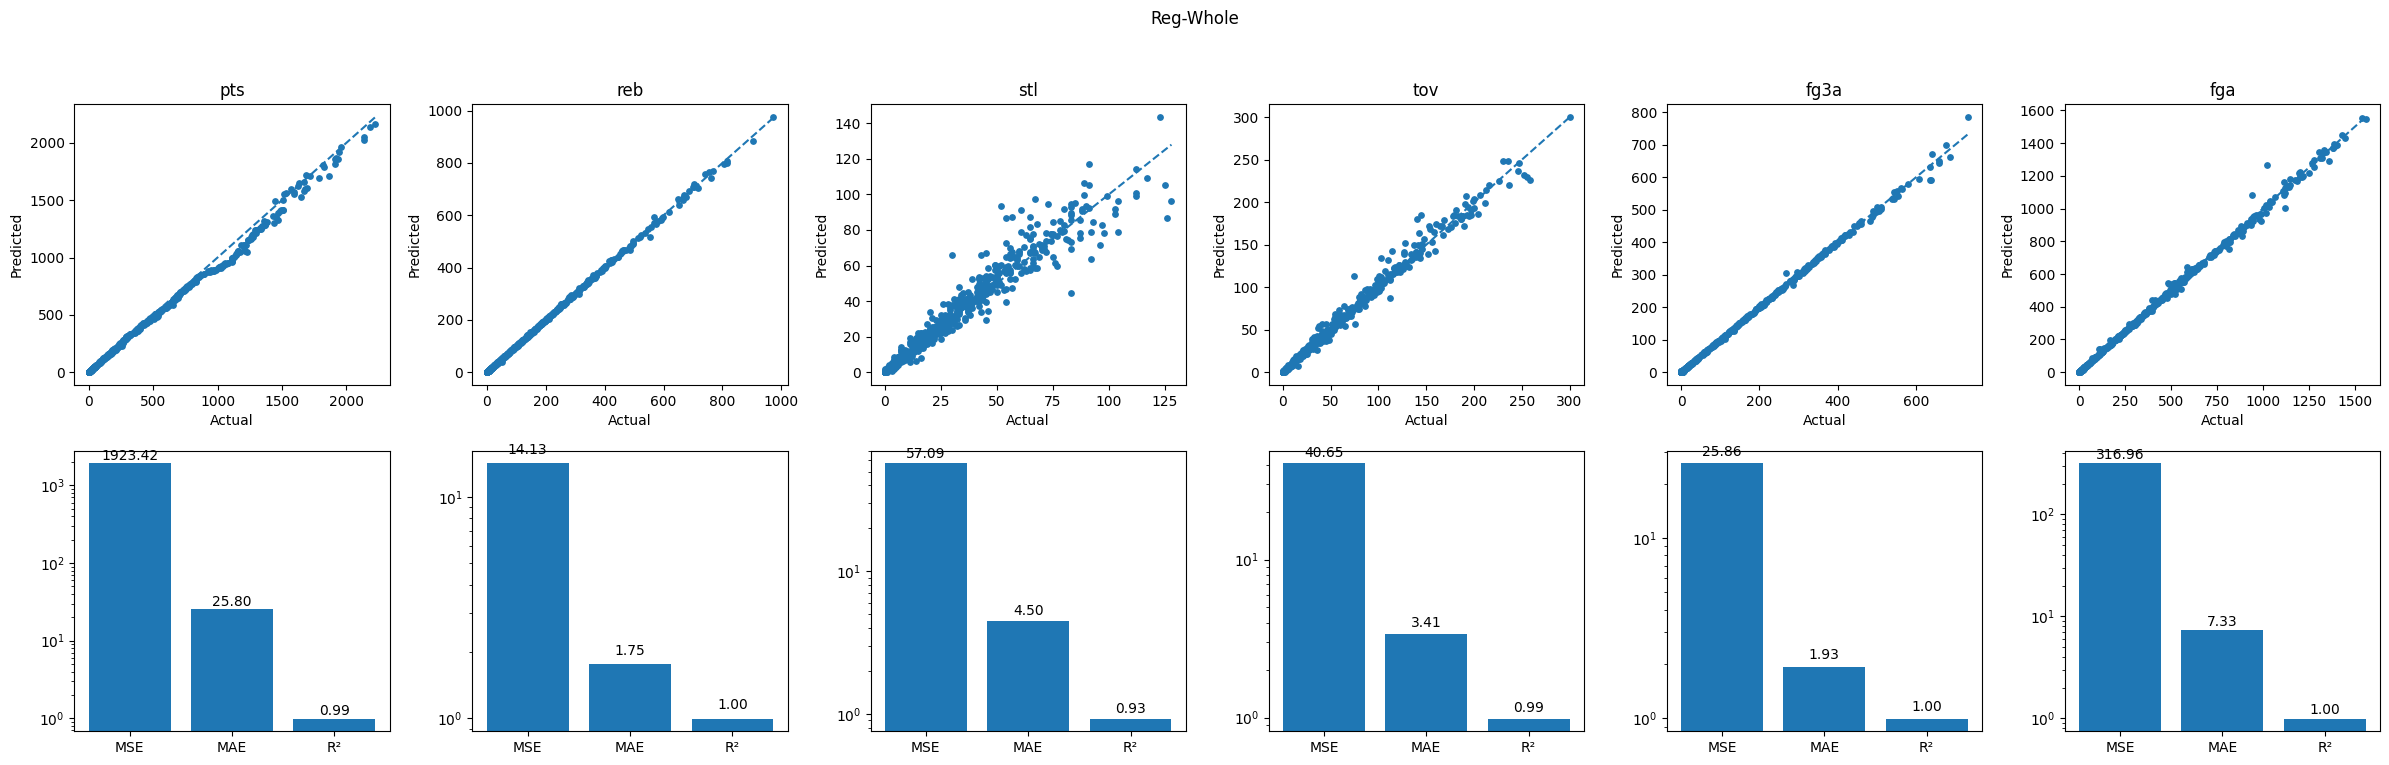

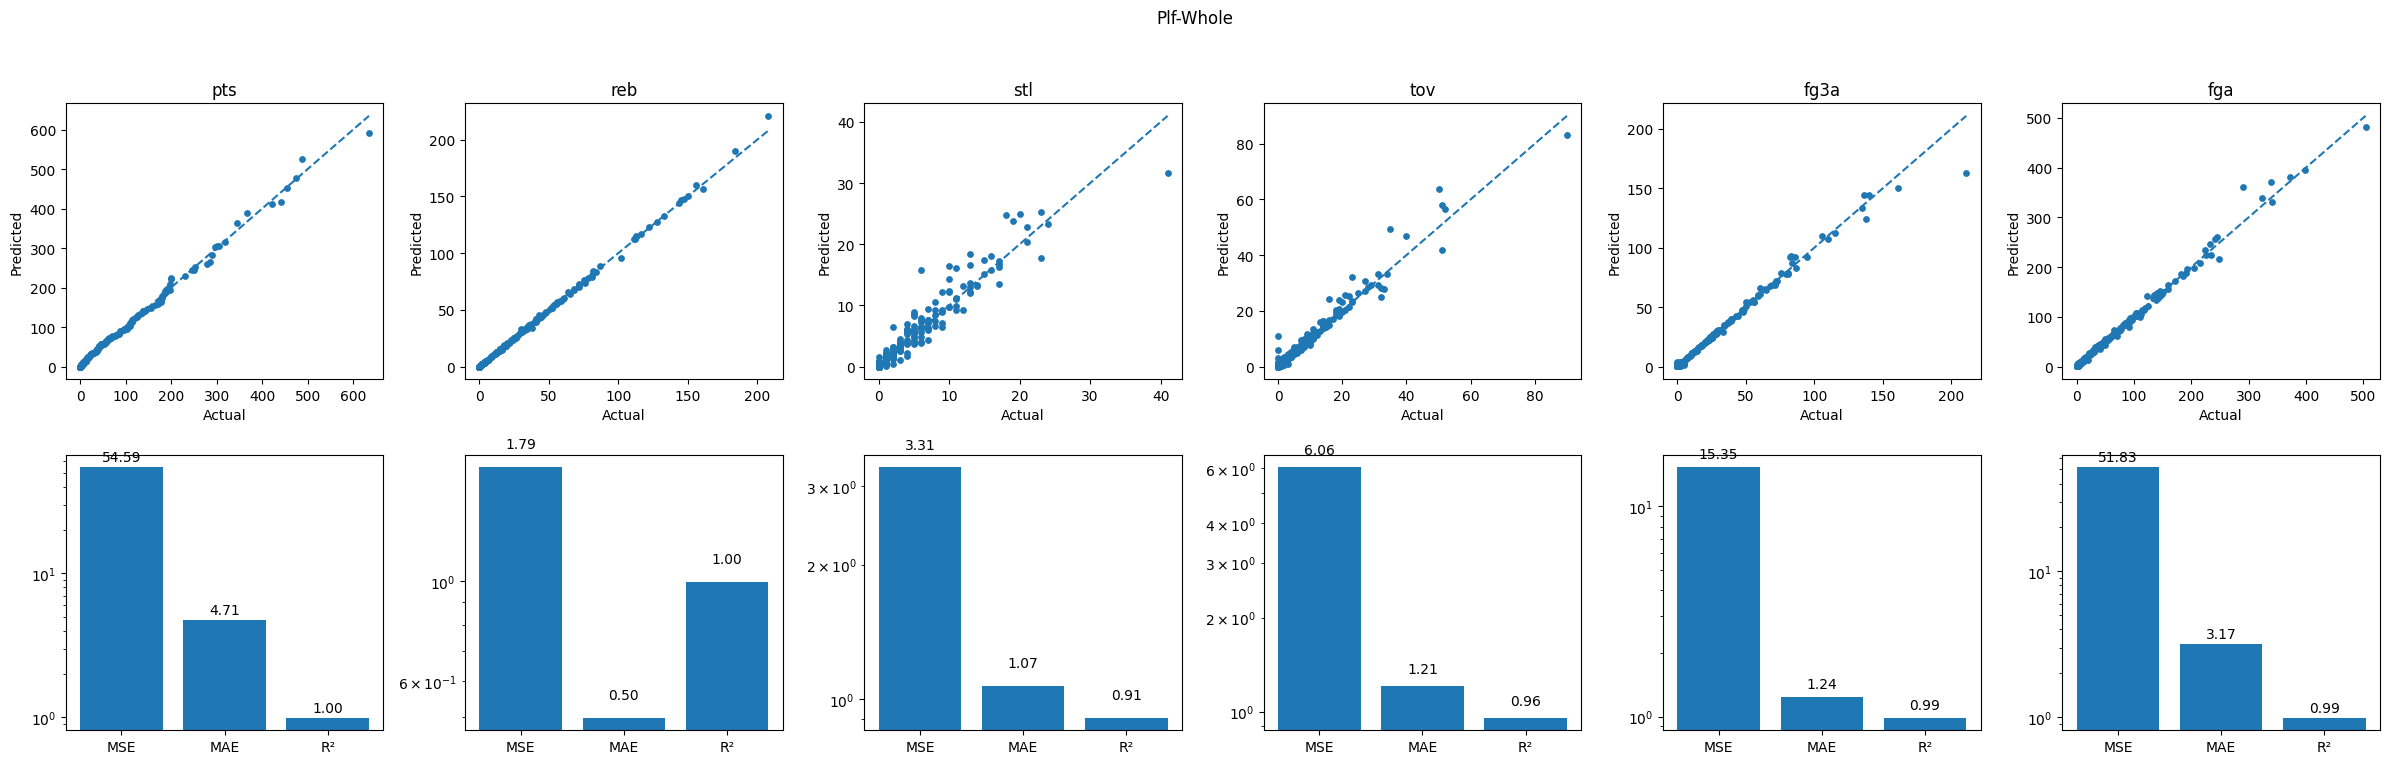

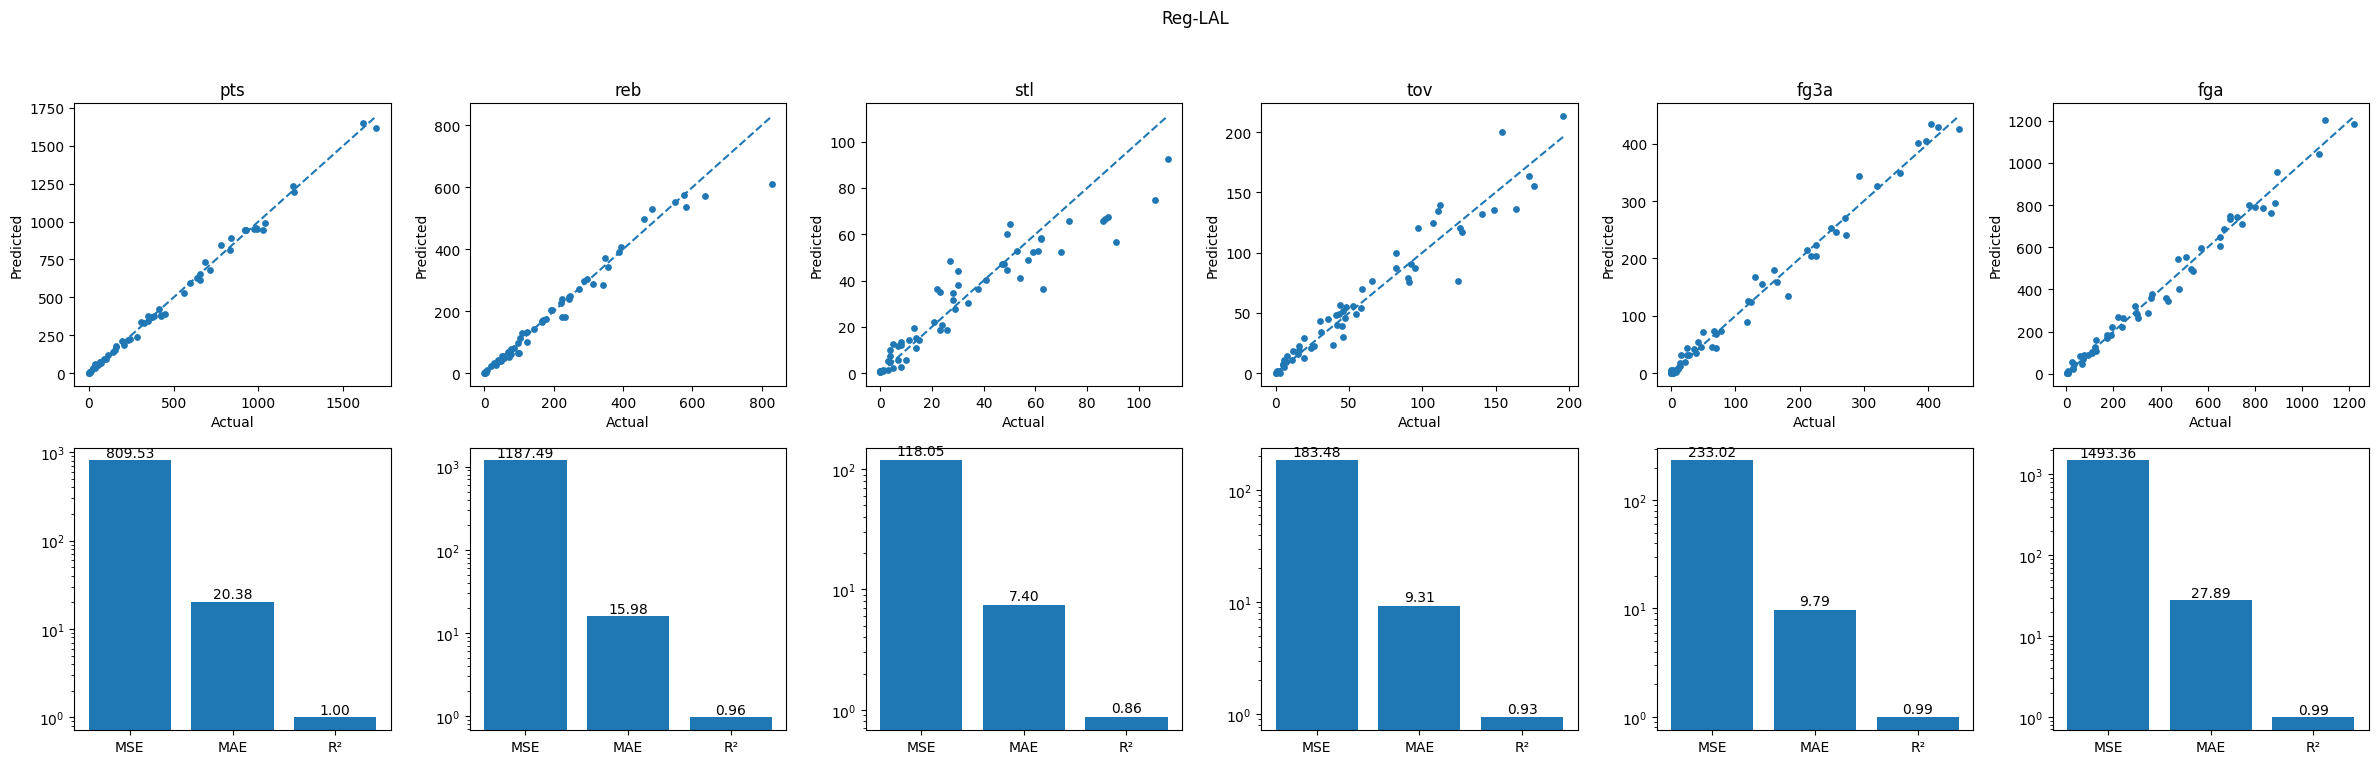

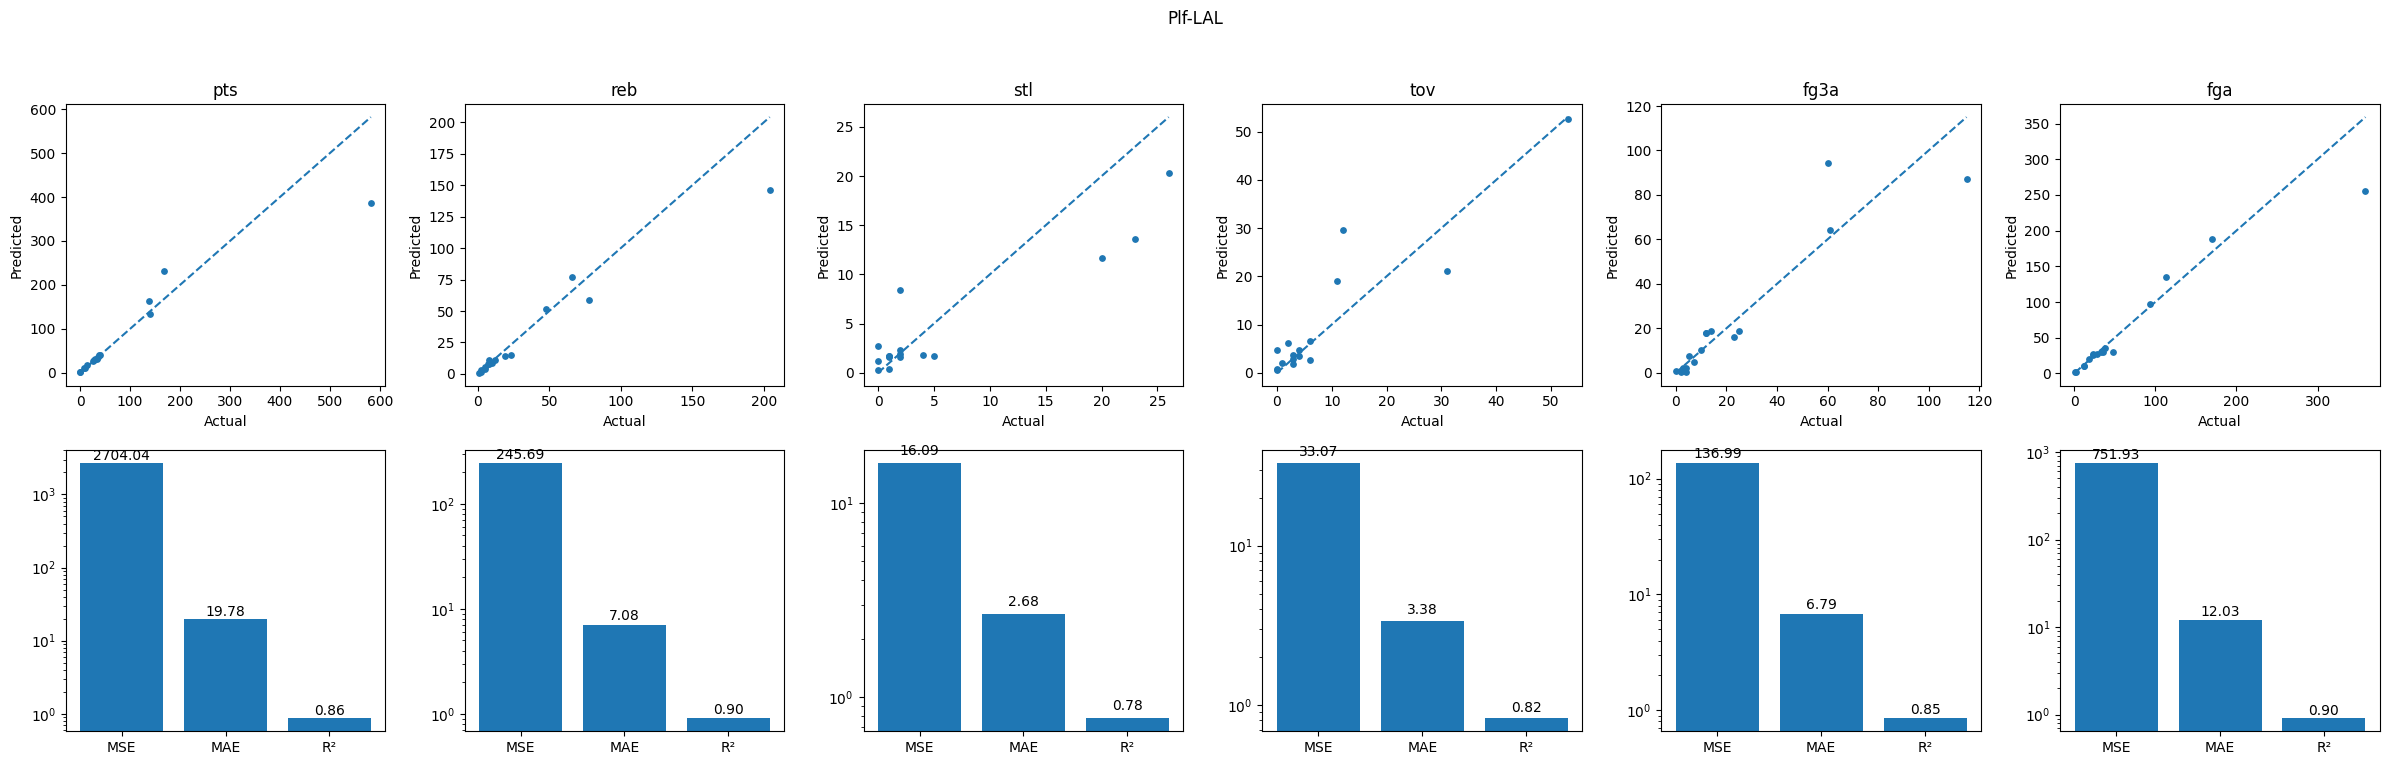

                MAE                                                       \
Stat           fg3a        fga        pts        reb       stl       tov   
Scenario                                                                   
Plf-LAL    6.794375  12.030625  19.779375   7.084375  2.676875  3.381250   
Plf-Whole  1.235654   3.167122   4.711121   0.498551  1.070725  1.212009   
Reg-LAL    9.785833  27.887333  20.378667  15.981833  7.403833  9.307000   
Reg-Whole  1.928047   7.325105  25.801855   1.754007  4.496939  3.407582   

                 R²                                                    
Stat           fg3a       fga       pts       reb       stl       tov  
Scenario                                                               
Plf-LAL    0.848184  0.902938  0.860259  0.902285  0.778025  0.821475  
Plf-Whole  0.986544  0.992306  0.995152  0.998792  0.906745  0.956434  
Reg-LAL    0.986691  0.986023  0.995438  0.964723  0.863678  0.934763  
Reg-Whole  0.999000  0.997675  0.99

In [8]:
# Cell 3 ── Define your six core numeric targets and scenario list (no R10)
TARGETS = ["pts","reb","stl","tov","fg3a","fga"]

# scenarios ← only Whole and LAL, for Regular and Playoffs
scenarios = [
    ("Reg-Whole", df_reg_tr, df_reg_te),
    ("Plf-Whole", df_plf_tr, df_plf_te),
    ("Reg-LAL", *train_test_split(pd.concat([df_reg_tr, df_reg_te])
                                   .query("team=='LAL'"),
                                  test_size=0.3, random_state=42)),
    ("Plf-LAL", *train_test_split(pd.concat([df_plf_tr, df_plf_te])
                                   .query("team=='LAL'"),
                                  test_size=0.3, random_state=42)),
]

# Cell 4 ── Preprocess function
import pandas as pd

def preprocess(df_tr, df_te, TARGET):
    X_tr = df_tr.drop(columns=[TARGET])
    X_te = df_te.drop(columns=[TARGET])
    y_tr = df_tr[TARGET]
    y_te = df_te[TARGET]
    for c in ['regular_season_index','playoff_index','player_id','player','team_id','team']:
        X_tr = X_tr.drop(columns=[c], errors='ignore')
        X_te = X_te.drop(columns=[c], errors='ignore')
    for c in X_tr.select_dtypes(include=['object']).columns:
        X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')
    X_tr = pd.get_dummies(X_tr, drop_first=True)
    X_te = pd.get_dummies(X_te, drop_first=True).reindex(columns=X_tr.columns, fill_value=0)
    return X_tr, X_te, y_tr, y_te

# Cell 5 ── Build feature / multi-Y matrices for each scenario
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

results = []
for name, dtr, dte in scenarios:
    # preprocess all TARGETS at once
    # start by doing pts then drop all TARGET columns from X
    X_tr, X_te, _, _ = preprocess(dtr, dte, TARGET=TARGETS[0])
    for t in TARGETS:
        X_tr = X_tr.drop(columns=[t], errors='ignore')
        X_te = X_te.drop(columns=[t], errors='ignore')
    Y_tr = dtr[TARGETS].apply(pd.to_numeric, errors='coerce')
    Y_te = dte[TARGETS].apply(pd.to_numeric, errors='coerce')

    # train & predict multi-output
    m = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    m.fit(X_tr, Y_tr)
    Y_pr = m.predict(X_te)

    # evaluate & plot
    n = len(TARGETS)
    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
    fig.suptitle(name)
    for i, stat in enumerate(TARGETS):
        y_true = Y_te[stat].to_numpy()
        y_hat  = Y_pr[:, i]

        # scatter
        ax = axes[0, i]
        ax.scatter(y_true, y_hat, s=15)
        mn, mx = y_true.min(), y_true.max()
        ax.plot([mn,mx],[mn,mx],"--")
        ax.set_title(stat)
        ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")

        # metrics bar
        mse = mean_squared_error(y_true, y_hat)
        mae = mean_absolute_error(y_true, y_hat)
        r2  = r2_score(y_true, y_hat)
        ax2 = axes[1, i]
        ax2.bar(["MSE","MAE","R²"], [mse, mae, abs(r2)])
        ax2.set_yscale("log")
        for j, v in enumerate([mse, mae, r2]):
            ax2.text(j, abs(v)*1.1, f"{v:.2f}", ha='center')

        results.append({"Scenario":name, "Stat":stat, "MAE":mae, "R²":r2})

    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

# summary table
import pandas as pd
df_res = pd.DataFrame(results)
print(df_res.pivot(index="Scenario", columns="Stat", values=["MAE","R²"]))


In [9]:
import joblib
import os
from pathlib import Path

# Define the filename for your saved model
model_filename = "nba_model.pkl"

# Define the directory to save the model (e.g., create a 'models' directory)
project_root = Path().resolve().parent # Assuming notebook is in notebooks/
models_dir = project_root / "models"
os.makedirs(models_dir, exist_ok=True) # Create the directory if it doesn't exist
model_filepath = models_dir / model_filename

# Save the trained model object 'm' to the file
joblib.dump(m, model_filepath)

print(f"Model saved to: {model_filepath}")

Model saved to: C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\models\nba_model.pkl


In [10]:
# CORRECTED Cell 7 ── Includes scenario definition, trains, evaluates, AND SAVES PLOTS

# --- First, define the necessary imports and data loading ---
from pathlib import Path
import pandas as pd
import os
from sklearn.model_selection import train_test_split # Needed for LAL scenarios
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Define data paths and load initial dataframes ---
project_root = Path().resolve().parent # Assuming notebook is in notebooks/
processed_dir = project_root / "processed"

df_reg_tr = pd.read_csv(os.path.join(processed_dir, "regular_train.csv"))
df_reg_te = pd.read_csv(os.path.join(processed_dir, "regular_test.csv"))
df_plf_tr = pd.read_csv(os.path.join(processed_dir, "playoff_train.csv"))
df_plf_te = pd.read_csv(os.path.join(processed_dir, "playoff_test.csv"))

# --- Define TARGETS ---
TARGETS = ["pts", "reb", "stl", "tov", "fg3a", "fga"] # From original Cell 2

# --- Define preprocess function ---
def preprocess(df_tr, df_te, TARGET):
    # (Keep the preprocess function definition from original Cell 4 here)
    X_tr = df_tr.drop(columns=[TARGET])
    X_te = df_te.drop(columns=[TARGET])
    y_tr = df_tr[TARGET]
    y_te = df_te[TARGET]
    for c in ['regular_season_index','playoff_index','player_id','player','team_id','team']:
        X_tr = X_tr.drop(columns=[c], errors='ignore')
        X_te = X_te.drop(columns=[c], errors='ignore')
    for c in X_tr.select_dtypes(include=['object']).columns:
        X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')
    X_tr = pd.get_dummies(X_tr, drop_first=True)
    # Align columns after one-hot encoding, handling potential missing columns in test set
    X_te = pd.get_dummies(X_te, drop_first=True)
    X_te = X_te.reindex(columns=X_tr.columns, fill_value=0)
    # Ensure no columns are left in X_te that are not in X_tr (might happen with sparse categories)
    X_te = X_te[X_tr.columns]
    return X_tr, X_te, y_tr, y_te

# --- Define the 'scenarios' list ---
# This combines data loading and scenario definition from original Cells 1, 3, and parts of 6
scenarios = [
    ("Reg-Whole", df_reg_tr, df_reg_te),
    ("Plf-Whole", df_plf_tr, df_plf_te),
    ("Reg-LAL", *train_test_split(pd.concat([df_reg_tr, df_reg_te])
                                   .query("team=='LAL'"),
                                  test_size=0.3, random_state=42)),
    ("Plf-LAL", *train_test_split(pd.concat([df_plf_tr, df_plf_te])
                                   .query("team=='LAL'"),
                                  test_size=0.3, random_state=42)),
]
# ---------------------------------

# --- Define output directory for plots ---
plots_dir = project_root / "plots"
os.makedirs(plots_dir, exist_ok=True) # Create the directory if it doesn't exist
# -----------------------------------------

results = []
# --- Loop through scenarios, preprocess, train, evaluate, plot, and save ---
for name, dtr, dte in scenarios:
    # Preprocess all TARGETS at once
    # Start by doing one target (e.g., pts) to get initial X shapes, then drop all targets
    X_tr_full, X_te_full, _, _ = preprocess(dtr, dte, TARGET=TARGETS[0])
    X_tr = X_tr_full.drop(columns=TARGETS, errors='ignore')
    X_te = X_te_full.drop(columns=TARGETS, errors='ignore')

    # Create multi-output Y matrices, handling potential NaNs
    Y_tr = dtr[TARGETS].apply(pd.to_numeric, errors='coerce').fillna(0)
    Y_te = dte[TARGETS].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Align columns just in case preprocessing introduced differences not caught before
    common_cols = X_tr.columns.intersection(X_te.columns)
    X_tr = X_tr[common_cols]
    X_te = X_te[common_cols]


    # Train & predict multi-output
    m = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    m.fit(X_tr, Y_tr)
    Y_pr = m.predict(X_te)

    # Evaluate & plot
    n = len(TARGETS)
    fig, axes = plt.subplots(2, n, figsize=(4*n, 8)) # Keep the figure object
    fig.suptitle(name)
    for i, stat in enumerate(TARGETS):
        y_true = Y_te[stat].to_numpy()
        y_hat  = Y_pr[:, i]

        # Scatter plot
        ax = axes[0, i]
        ax.scatter(y_true, y_hat, s=15, alpha=0.7)
        mn, mx = y_true.min(), y_true.max()
        if mn == mx: # Handle cases where min equals max
            mn -= 1
            mx += 1
        ax.plot([mn,mx],[mn,mx],"--", color='red')
        ax.set_title(stat)
        ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")

        # Metrics bar chart
        mse = mean_squared_error(y_true, y_hat)
        mae = mean_absolute_error(y_true, y_hat)
        r2  = r2_score(y_true, y_hat)
        ax2 = axes[1, i]
        metrics_labels = ["MSE", "MAE", "R²"]
        # Use absolute values for bar heights if using log scale, ensure non-zero before log
        metrics_values_plot = [max(abs(v), 1e-9) for v in [mse, mae, r2]] # Avoid log(0) or log(negative)
        ax2.bar(metrics_labels, metrics_values_plot)
        ax2.set_yscale("log")
        # Display original metric values as text
        for j, v in enumerate([mse, mae, r2]):
            ax2.text(j, metrics_values_plot[j] * 1.1, f"{v:.2f}", ha='center')

        results.append({"Scenario":name, "Stat":stat, "MAE":mae, "R²":r2})

    plt.tight_layout(rect=[0,0.03,1,0.95])

    # --- Save the entire figure for the current scenario ---
    plot_filename = f"{name}_evaluation_plots.png"
    plot_filepath = plots_dir / plot_filename
    fig.savefig(plot_filepath)
    print(f"Saved plot for scenario '{name}' to: {plot_filepath}")
    plt.close(fig) # Close the figure
    # ------------------------------------------------------

# --- Summary table ---
df_res = pd.DataFrame(results)
df_res_pivot = df_res.pivot(index="Scenario", columns="Stat", values=["MAE", "R²"])
print("\nEvaluation Metrics Summary:")
print(df_res_pivot)
# --------------------

# --- Optionally save the results table to CSV ---
# table_filename = "model_evaluation_summary.csv"
# table_filepath = plots_dir / table_filename
# df_res_pivot.to_csv(table_filepath)
# print(f"Saved summary table to: {table_filepath}")
# ---------------------------------------------------

Saved plot for scenario 'Reg-Whole' to: C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\plots\Reg-Whole_evaluation_plots.png
Saved plot for scenario 'Plf-Whole' to: C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\plots\Plf-Whole_evaluation_plots.png
Saved plot for scenario 'Reg-LAL' to: C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\plots\Reg-LAL_evaluation_plots.png
Saved plot for scenario 'Plf-LAL' to: C:\Users\bbalt\Downloads\endreport\nba-prediction-project\.venv\Scripts\plots\Plf-LAL_evaluation_plots.png

Evaluation Metrics Summary:
                MAE                                                       \
Stat           fg3a        fga        pts        reb       stl       tov   
Scenario                                                                   
Plf-LAL    6.794375  12.030625  19.779375   7.084375  2.676875  3.381250   
Plf-Whole  1.235654   3.167122   4.711121   0.498551  1.070725  1.212009   
Reg